In [1]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt

# constructing the telescope:
wf_npixels = 256 # nice and low res
diameter = 0.125
period = 304e-6
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 300
true_pixel_scale = 0.375
oversample = 4 # high level oversample

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,true_pixel_scale,oversample)

In [2]:
import pandas as pd
from scipy.stats import binned_statistic

# Step 1: Load from CSV
df = pd.read_csv("alpha_cen_A_spectrum.csv")  # replace with correct path if needed

# Step 2: Apply mask (wavelengths in Ångstroms, like original)
mask = (df["wavelength"] >= 5200) & (df["wavelength"] <= 6500)

# Step 3: Extract and convert to meters
wavelengths = df["wavelength"][mask].to_numpy() * 1e-10  # meters
weights = df["flux"][mask].to_numpy()

# Step 4: Downsample using binning
n_bins = 500
bin_means, bin_edges, _ = binned_statistic(
    wavelengths, weights, statistic='mean', bins=n_bins
)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 5: Create the point source
alpha_cen_a_source = dl.PointSource(
    wavelengths=bin_centers,
    weights=bin_means,
    flux=1e6
)

In [3]:
alpha_cen_a_scope = dl.Telescope(optics,alpha_cen_a_source)

sidelobescope = dlT.SideLobeTelescope(alpha_cen_a_scope, period, difference)

In [4]:
center_wl = 585e-9
pixel_scale = 0.375
# make sure to downsample!
sidelobes = dlu.downsample(sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = pixel_scale),4,False)

Model time: 28.0506 seconds.


In [79]:
# let's try recreating the figure but better this time:
weights_path = 'telescope.source.spectrum.weights'

model = sidelobescope.set(weights_path, np.ones(n_bins)/n_bins)
#print(model)
model_psf = dlu.downsample(model.model_sidelobes(float(center_wl)),4,False)

import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

weights_optimiser = optax.adam(1e-4)

optim, opt_state = zdx.get_optimiser(model, weights_path, weights_optimiser)

out = dlu.downsample(model.model_sidelobes(float(center_wl)),4,False)

Model time: 24.2242 seconds.
Model time: 26.0820 seconds.


In [ ]:
@zdx.filter_jit
@zdx.filter_value_and_grad(weights_path)
def loss_fn(model, data):
    out = dlu.downsample(model.model_sidelobes(center_wl),4,False)
    return np.sum((data - out)**2)

In [81]:
%%time
loss, grads = loss_fn(model, sidelobes) # Compile
print("Initial Loss: {}".format(int(loss)))

Model time: 7.1918 seconds.
Initial Loss: 17597
CPU times: user 2min 31s, sys: 4.04 s, total: 2min 35s
Wall time: 58.9 s


In [82]:
import jax

In [87]:
from tqdm import tqdm

losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobes)    
        updates, opt_state = optim.update(grads, opt_state)
        #print(updates.source.weights[0])
        # prevent negative weights
        # Get current weights
        weights = model.get(weights_path)

        print(weights[0])
        # # Get update for weights
        weight_updates = updates.get(weights_path)
        print(weight_updates[0])
        # # Clamp the update: ensure weights + update >= 0
        epsilon = 1e-6
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)
        print(safe_updates[0])
        # # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)
        

        # Now apply
        model = zdx.apply_updates(model, updates)

        model = model.set(weights_path, np.maximum(np.zeros(n_bins),model.telescope.source.spectrum.weights))
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Log Loss: 3.710:   1%|          | 1/100 [00:13<22:29, 13.63s/it]

0.0014105913
-9.381285e-05
-9.381285e-05


Log Loss: 3.616:   2%|▏         | 2/100 [00:26<21:05, 12.91s/it]

0.0013167785
-9.1835864e-05
-9.1835864e-05


Log Loss: 3.519:   3%|▎         | 3/100 [00:39<20:59, 12.98s/it]

0.0012249426
-8.9612986e-05
-8.9612986e-05


Log Loss: 3.418:   4%|▍         | 4/100 [00:52<21:05, 13.18s/it]

0.0011353296
-8.715792e-05
-8.715792e-05


Log Loss: 3.313:   5%|▌         | 5/100 [01:06<21:12, 13.39s/it]

0.0010481717
-8.4485975e-05
-8.4485975e-05


Log Loss: 3.205:   6%|▌         | 6/100 [01:20<21:14, 13.56s/it]

0.0009636857
-8.1613376e-05
-8.1613376e-05


Log Loss: 3.095:   7%|▋         | 7/100 [01:34<21:15, 13.71s/it]

0.0008820723
-7.855669e-05
-7.855669e-05


Log Loss: 2.984:   8%|▊         | 8/100 [01:48<21:21, 13.93s/it]

0.0008035156
-7.533375e-05
-7.533375e-05


Log Loss: 2.873:   9%|▉         | 9/100 [02:02<21:17, 14.04s/it]

0.00072818185
-7.196293e-05
-7.196293e-05


Log Loss: 2.765:  10%|█         | 10/100 [02:17<21:18, 14.20s/it]

0.0006562189
-6.8463756e-05
-6.8463756e-05


Log Loss: 2.663:  11%|█         | 11/100 [02:31<21:10, 14.28s/it]

0.0005877552
-6.485619e-05
-6.485619e-05


Log Loss: 2.569:  12%|█▏        | 12/100 [02:46<21:04, 14.37s/it]

0.000522899
-6.1160834e-05
-6.1160834e-05


Log Loss: 2.487:  13%|█▎        | 13/100 [03:01<20:56, 14.44s/it]

0.00046173815
-5.7398483e-05
-5.7398483e-05


Log Loss: 2.418:  14%|█▍        | 14/100 [03:15<20:46, 14.49s/it]

0.00040433966
-5.358989e-05
-5.358989e-05


Log Loss: 2.365:  15%|█▌        | 15/100 [03:30<20:35, 14.54s/it]

0.00035074976
-4.975557e-05
-4.975557e-05


Log Loss: 2.329:  16%|█▌        | 16/100 [03:45<20:31, 14.66s/it]

0.0003009942
-4.5916033e-05
-4.5916033e-05


Log Loss: 2.307:  17%|█▋        | 17/100 [04:00<20:33, 14.86s/it]

0.00025507816
-4.2091415e-05
-4.2091415e-05


Log Loss: 2.297:  18%|█▊        | 18/100 [04:15<20:21, 14.90s/it]

0.00021298675
-3.8301674e-05
-3.8301674e-05


Log Loss: 2.294:  19%|█▉        | 19/100 [04:30<20:05, 14.89s/it]

0.00017468508
-3.4566285e-05
-3.4566285e-05


Log Loss: 2.297:  20%|██        | 20/100 [04:45<19:47, 14.85s/it]

0.00014011879
-3.090407e-05
-3.090407e-05


Log Loss: 2.300:  21%|██        | 21/100 [05:00<19:35, 14.88s/it]

0.00010921472
-2.7333012e-05
-2.7333012e-05


Log Loss: 2.304:  22%|██▏       | 22/100 [05:15<19:21, 14.89s/it]

8.1881706e-05
-2.3869854e-05
-2.3869854e-05


Log Loss: 2.305:  23%|██▎       | 23/100 [05:30<19:14, 15.00s/it]

5.801185e-05
-2.0530118e-05
-2.0530118e-05


Log Loss: 2.301:  24%|██▍       | 24/100 [05:45<18:57, 14.97s/it]

3.7481732e-05
-1.7331824e-05
-1.7331824e-05


Log Loss: 2.291:  25%|██▌       | 25/100 [06:00<18:41, 14.95s/it]

2.0149908e-05
-1.4288647e-05
-1.4288647e-05


Log Loss: 2.276:  26%|██▌       | 26/100 [06:15<18:23, 14.92s/it]

5.8612604e-06
-1.14100285e-05
-4.8612605e-06


Log Loss: 2.255:  27%|██▋       | 27/100 [06:29<18:08, 14.91s/it]

9.999999e-07
-8.720696e-06
1.1368684e-13


Log Loss: 2.229:  28%|██▊       | 28/100 [06:44<17:55, 14.94s/it]

1e-06
-6.2534355e-06
0.0


Log Loss: 2.199:  29%|██▉       | 29/100 [07:00<17:51, 15.09s/it]

1e-06
-3.9988254e-06
0.0


Log Loss: 2.166:  30%|███       | 30/100 [07:15<17:44, 15.20s/it]

1e-06
-1.9417869e-06
0.0


Log Loss: 2.130:  31%|███       | 31/100 [07:30<17:25, 15.15s/it]

1e-06
-6.7272296e-08
0.0


Log Loss: 2.091:  32%|███▏      | 32/100 [07:45<17:05, 15.08s/it]

1e-06
1.6386726e-06
1.6386726e-06


Log Loss: 2.051:  33%|███▎      | 33/100 [08:00<16:50, 15.08s/it]

2.6386726e-06
3.1789314e-06
3.1789314e-06


Log Loss: 2.008:  34%|███▍      | 34/100 [08:15<16:32, 15.04s/it]

5.817604e-06
4.556181e-06
4.556181e-06


Log Loss: 1.962:  35%|███▌      | 35/100 [08:31<16:30, 15.23s/it]

1.0373785e-05
5.773948e-06
5.773948e-06


Log Loss: 1.914:  36%|███▌      | 36/100 [08:46<16:11, 15.17s/it]

1.6147733e-05
6.836529e-06
6.836529e-06


Log Loss: 1.862:  37%|███▋      | 37/100 [09:01<15:50, 15.09s/it]

2.2984263e-05
7.748935e-06
7.748935e-06


Log Loss: 1.806:  38%|███▊      | 38/100 [09:16<15:36, 15.10s/it]

3.0733197e-05
8.516847e-06
8.516847e-06


Log Loss: 1.746:  39%|███▉      | 39/100 [09:31<15:18, 15.05s/it]

3.9250044e-05
9.146515e-06
9.146515e-06


Log Loss: 1.684:  40%|████      | 40/100 [09:46<15:03, 15.05s/it]

4.839656e-05
9.644703e-06
9.644703e-06


Log Loss: 1.619:  41%|████      | 41/100 [10:01<14:48, 15.06s/it]

5.8041263e-05
1.0018587e-05
1.0018587e-05


Log Loss: 1.553:  42%|████▏     | 42/100 [10:16<14:32, 15.05s/it]

6.805985e-05
1.0275674e-05
1.0275674e-05


Log Loss: 1.487:  43%|████▎     | 43/100 [10:31<14:16, 15.02s/it]

7.833553e-05
1.0423744e-05
1.0423744e-05


Log Loss: 1.423:  44%|████▍     | 44/100 [10:46<14:02, 15.04s/it]

8.8759276e-05
1.0470737e-05
1.0470737e-05


Log Loss: 1.359:  45%|████▌     | 45/100 [11:01<13:47, 15.05s/it]

9.923001e-05
1.0424654e-05
1.0424654e-05


Log Loss: 1.297:  46%|████▌     | 46/100 [11:16<13:33, 15.06s/it]

0.00010965466
1.029353e-05
1.029353e-05


Log Loss: 1.236:  47%|████▋     | 47/100 [11:31<13:17, 15.05s/it]

0.00011994819
1.0085343e-05
1.0085343e-05


Log Loss: 1.178:  48%|████▊     | 48/100 [11:47<13:06, 15.12s/it]

0.00013003353
9.8080345e-06
9.8080345e-06


Log Loss: 1.122:  49%|████▉     | 49/100 [12:02<12:49, 15.09s/it]

0.00013984156
9.469424e-06
9.469424e-06


Log Loss: 1.068:  50%|█████     | 50/100 [12:17<12:36, 15.13s/it]

0.00014931099
9.077221e-06
9.077221e-06


Log Loss: 1.018:  51%|█████     | 51/100 [12:32<12:19, 15.10s/it]

0.00015838821
8.638998e-06
8.638998e-06


Log Loss: 0.970:  52%|█████▏    | 52/100 [12:47<12:03, 15.08s/it]

0.0001670272
8.162163e-06
8.162163e-06


Log Loss: 0.926:  53%|█████▎    | 53/100 [13:02<11:48, 15.07s/it]

0.00017518937
7.653935e-06
7.653935e-06


Log Loss: 0.886:  54%|█████▍    | 54/100 [13:17<11:33, 15.08s/it]

0.0001828433
7.1213e-06
7.1213e-06


Log Loss: 0.850:  55%|█████▌    | 55/100 [13:32<11:19, 15.10s/it]

0.0001899646
6.5709596e-06
6.5709596e-06


Log Loss: 0.818:  56%|█████▌    | 56/100 [13:47<11:03, 15.07s/it]

0.00019653556
6.0093103e-06
6.0093103e-06


Log Loss: 0.790:  57%|█████▋    | 57/100 [14:02<10:50, 15.12s/it]

0.00020254488
5.442393e-06
5.442393e-06


Log Loss: 0.762:  58%|█████▊    | 58/100 [14:17<10:33, 15.08s/it]

0.00020798726
4.875847e-06
4.875847e-06


Log Loss: 0.734:  59%|█████▉    | 59/100 [14:33<10:18, 15.09s/it]

0.00021286312
4.3148816e-06
4.3148816e-06


Log Loss: 0.705:  60%|██████    | 60/100 [14:48<10:02, 15.07s/it]

0.00021717799
3.7642537e-06
3.7642537e-06


Log Loss: 0.673:  61%|██████    | 61/100 [15:03<09:47, 15.06s/it]

0.00022094225
3.2282414e-06
3.2282414e-06


Log Loss: 0.638:  62%|██████▏   | 62/100 [15:18<09:31, 15.05s/it]

0.0002241705
2.7106362e-06
2.7106362e-06


Log Loss: 0.602:  63%|██████▎   | 63/100 [15:33<09:18, 15.09s/it]

0.00022688112
2.214707e-06
2.214707e-06


Log Loss: 0.566:  64%|██████▍   | 64/100 [15:48<09:04, 15.12s/it]

0.00022909584
1.7432375e-06
1.7432375e-06


Log Loss: 0.528:  65%|██████▌   | 65/100 [16:04<08:53, 15.25s/it]

0.00023083907
1.298498e-06
1.298498e-06


Log Loss: 0.490:  66%|██████▌   | 66/100 [16:19<08:38, 15.25s/it]

0.00023213757
8.8228677e-07
8.8228677e-07


Log Loss: 0.452:  67%|██████▋   | 67/100 [16:34<08:24, 15.28s/it]

0.00023301985
4.95944e-07
4.95944e-07


Log Loss: 0.412:  68%|██████▊   | 68/100 [16:50<08:09, 15.30s/it]

0.00023351579
1.4040494e-07
1.4040494e-07


Log Loss: 0.372:  69%|██████▉   | 69/100 [17:05<07:54, 15.32s/it]

0.0002336562
-1.8376788e-07
-1.8376788e-07


Log Loss: 0.330:  70%|███████   | 70/100 [17:20<07:40, 15.34s/it]

0.00023347244
-4.7634126e-07
-4.7634126e-07


Log Loss: 0.288:  71%|███████   | 71/100 [17:36<07:25, 15.36s/it]

0.0002329961
-7.3737465e-07
-7.3737465e-07


Log Loss: 0.245:  72%|███████▏  | 72/100 [17:51<07:09, 15.36s/it]

0.00023225872
-9.671857e-07
-9.671857e-07


Log Loss: 0.201:  73%|███████▎  | 73/100 [18:06<06:54, 15.37s/it]

0.00023129155
-1.1663367e-06
-1.1663367e-06


Log Loss: 0.158:  74%|███████▍  | 74/100 [18:22<06:38, 15.34s/it]

0.00023012521
-1.3355879e-06
-1.3355879e-06


Log Loss: 0.114:  75%|███████▌  | 75/100 [18:37<06:23, 15.34s/it]

0.00022878962
-1.4759205e-06
-1.4759205e-06


Log Loss: 0.071:  76%|███████▌  | 76/100 [18:52<06:08, 15.36s/it]

0.0002273137
-1.5884848e-06
-1.5884848e-06


Log Loss: 0.029:  77%|███████▋  | 77/100 [19:08<05:53, 15.37s/it]

0.00022572522
-1.6745934e-06
-1.6745934e-06


Log Loss: -0.015:  78%|███████▊  | 78/100 [19:23<05:37, 15.35s/it]

0.00022405063
-1.7356954e-06
-1.7356954e-06


Log Loss: -0.059:  79%|███████▉  | 79/100 [19:38<05:22, 15.34s/it]

0.00022231493
-1.7733756e-06
-1.7733756e-06


Log Loss: -0.104:  80%|████████  | 80/100 [19:54<05:07, 15.36s/it]

0.00022054157
-1.7893109e-06
-1.7893109e-06


Log Loss: -0.151:  81%|████████  | 81/100 [20:09<04:51, 15.36s/it]

0.00021875225
-1.7852585e-06
-1.7852585e-06


Log Loss: -0.198:  82%|████████▏ | 82/100 [20:25<04:37, 15.40s/it]

0.00021696699
-1.7630355e-06
-1.7630355e-06


Log Loss: -0.245:  83%|████████▎ | 83/100 [20:40<04:20, 15.34s/it]

0.00021520395
-1.7245002e-06
-1.7245002e-06


Log Loss: -0.290:  84%|████████▍ | 84/100 [20:55<04:05, 15.36s/it]

0.00021347945
-1.671526e-06
-1.671526e-06


Log Loss: -0.333:  85%|████████▌ | 85/100 [21:11<03:49, 15.33s/it]

0.00021180793
-1.6059859e-06
-1.6059859e-06


Log Loss: -0.375:  86%|████████▌ | 86/100 [21:26<03:34, 15.30s/it]

0.00021020194
-1.5297298e-06
-1.5297298e-06


Log Loss: -0.416:  87%|████████▋ | 87/100 [21:41<03:18, 15.29s/it]

0.00020867221
-1.4445741e-06
-1.4445741e-06


Log Loss: -0.457:  88%|████████▊ | 88/100 [21:56<03:02, 15.22s/it]

0.00020722764
-1.3522687e-06
-1.3522687e-06


Log Loss: -0.497:  89%|████████▉ | 89/100 [22:12<02:47, 15.26s/it]

0.00020587537
-1.2544951e-06
-1.2544951e-06


Log Loss: -0.537:  90%|█████████ | 90/100 [22:27<02:34, 15.41s/it]

0.00020462088
-1.1528612e-06
-1.1528612e-06


Log Loss: -0.575:  91%|█████████ | 91/100 [22:43<02:19, 15.46s/it]

0.00020346802
-1.0488689e-06
-1.0488689e-06


Log Loss: -0.612:  92%|█████████▏| 92/100 [22:58<02:03, 15.44s/it]

0.00020241915
-9.4390816e-07
-9.4390816e-07


Log Loss: -0.647:  93%|█████████▎| 93/100 [23:13<01:47, 15.33s/it]

0.00020147524
-8.392668e-07
-8.392668e-07


Log Loss: -0.682:  94%|█████████▍| 94/100 [23:29<01:32, 15.34s/it]

0.00020063597
-7.3609414e-07
-7.3609414e-07


Log Loss: -0.715:  95%|█████████▌| 95/100 [23:44<01:16, 15.30s/it]

0.00019989988
-6.354111e-07
-6.354111e-07


Log Loss: -0.748:  96%|█████████▌| 96/100 [23:59<01:01, 15.31s/it]

0.00019926447
-5.381195e-07
-5.381195e-07


Log Loss: -0.779:  97%|█████████▋| 97/100 [24:14<00:45, 15.28s/it]

0.00019872635
-4.4497958e-07
-4.4497958e-07


Log Loss: -0.808:  98%|█████████▊| 98/100 [24:30<00:30, 15.25s/it]

0.00019828137
-3.5663513e-07
-3.5663513e-07


Log Loss: -0.836:  99%|█████████▉| 99/100 [24:45<00:15, 15.22s/it]

0.00019792473
-2.736229e-07
-2.736229e-07


Log Loss: -0.863: 100%|██████████| 100/100 [25:00<00:00, 15.01s/it]

0.00019765111
-1.9638287e-07
-1.9638287e-07


Model time: 24.3618 seconds.


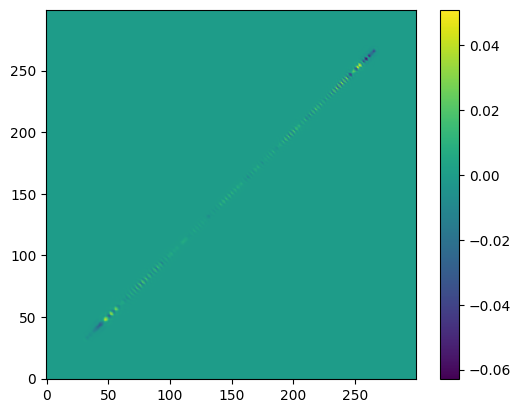

In [89]:
plt.imshow(dlu.downsample(models_out[99].model_sidelobes(center_wl),4,False)-sidelobes,origin='lower')
plt.colorbar()
plt.show()

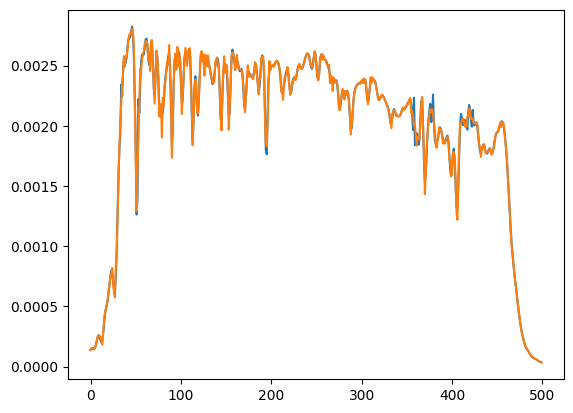

In [90]:
plt.plot((models_out[99].source.weights)/np.sum(models_out[99].source.weights))
plt.plot(bin_means/np.sum(bin_means))
plt.show()

In [78]:
print(np.min(models_out[28].source.weights))

nan


In [88]:
print(len(models_out))

100


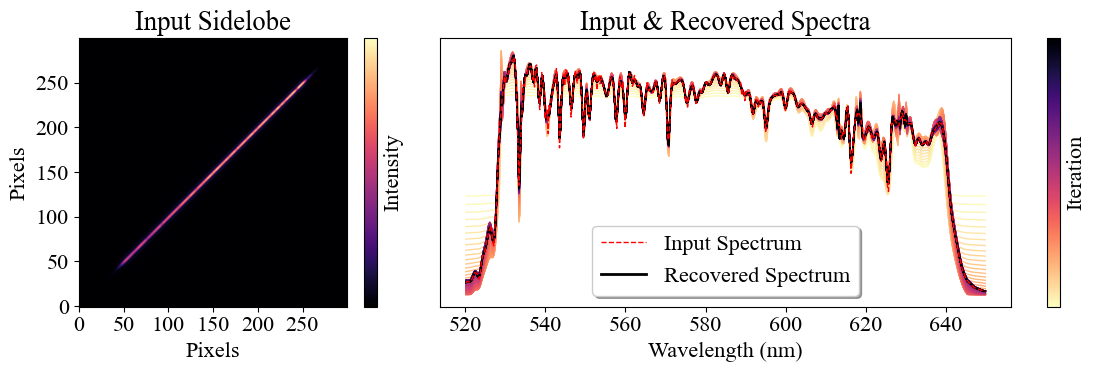

In [122]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Times New Roman font
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16

cmap = plt.get_cmap('magma')
norm = colors.Normalize(vmin=0, vmax=99)  # Normalize iteration range

# Create figure and gridspec
fig = plt.figure(figsize=(12,4))
gs = gridspec.GridSpec(1, 3, figure=fig)

# First subplot (column 1)
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(sidelobes, origin='lower', cmap=cmap)
ax1.set_title('Input Sidelobe')
ax1.set_xlabel('Pixels')
ax1.set_ylabel('Pixels')

tick_spacing = 50
image_shape = sidelobes.shape
ax1.set_xticks(np.arange(0, image_shape[1], tick_spacing))
ax1.set_yticks(np.arange(0, image_shape[0], tick_spacing))

cbar1 = fig.colorbar(im, ax=ax1)
cbar1.set_ticks([])  # remove tick marks and labels
cbar1.ax.set_ylabel('Intensity')

# Second subplot spans columns 2 and 3
ax2 = fig.add_subplot(gs[0, 1:3])

for i in range(100):
    output_weights = models_out[i].telescope.source.spectrum.weights / np.sum(models_out[i].telescope.source.spectrum.weights)
    color = cmap(1 - i / 99)
    ax2.plot(bin_centers * 1e9, output_weights, color=color, linewidth=1)

ax2.tick_params(axis='y', left=False, labelleft=False)
ax2.set_xlabel("Wavelength (nm)")
ax2.set_title("Input & Recovered Spectra")

# Overlay true spectrum
ax2.plot(bin_centers * 1e9, sidelobescope.telescope.source.spectrum.weights, color='red', linestyle='--', linewidth=1, label='Input Spectrum')
# Create a fake gradient entry using a Patch with the colormap
gradient_patch =  Line2D([0], [0], color='black', linestyle='-', label='Recovered Spectrum', linewidth=2)

# Existing legend items
input_line = Line2D([0], [0], color='red', linestyle='--', label='Input Spectrum', linewidth=1)

# Combine and add to legend
ax2.legend(handles=[input_line, gradient_patch], loc='lower center', shadow=True)
#ax2.legend(shadow=True,loc='lower center')
# Colorbar for iterations
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar2 = fig.colorbar(sm, ax=ax2, label="Iteration")
cbar2.ax.invert_yaxis()
cbar2.set_ticks([])

plt.tight_layout()
#plt.savefig('input_recovered_magma_blue.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [119]:
# saving stuff
import pickle

# Save sidelobes (original, not downsampled)
np.save("sidelobes_tol.npy", sidelobes)

# Save bin_centers (in meters, as in original code)
np.save("bin_centers_tol.npy", bin_centers)

# Save input spectrum weights
np.save("input_weights_tol.npy", sidelobescope.telescope.source.spectrum.weights)

# Save model outputs: 100 arrays of weights
output_weights_list = [model.telescope.source.spectrum.weights for model in models_out]
with open("output_weights_tol.pkl", "wb") as f:
    pickle.dump(output_weights_list, f)
